# KOSMOZ: Amazon Yorumları için Duygu Analizi

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

## Görev 1: Metin Ön İşleme

### Adım 1: amazon.xlsx verisini okutunuz.

In [2]:
df = pd.read_excel("amazon.xlsx")

### Adım 2: Review değişkeni üzerinde;

#### a. Tüm harfleri küçük harfe çeviriniz

In [3]:
df["Review"] = df["Review"].str.lower()

df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

#### b. Noktalama işaretlerini çıkarınız

In [4]:
df["Review"] = df["Review"].str.replace("[^\w\s]","")

df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

#### c. Yorumlarda bulunan sayısal ifadeleri çıkarınız.

In [5]:
df["Review"] = df["Review"].str.replace("\d","")

df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

#### d. Bilgi içermeyen kelimeleri (stopwords) veriden çıkarınız.

In [6]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\berka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
sw = stopwords.words("english")
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [8]:
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["Review"]

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

#### e. 1'den az geçen kelimeleri veriden çıkarınız

In [9]:
temp_df = pd.Series(" ".join(df["Review"]).split()).value_counts()

drops = temp_df[temp_df <= 1]

df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

df["Review"]

0                                                   happy
1                    good quality material however panels
2       product fun bedroom windowsbr imagery bit stre...
3                               lo que es que un poco mas
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme area phot...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

#### f. Lemmatization işlemini uygulayınız.

In [10]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\berka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df["Review"]

0                                                   happy
1                     good quality material however panel
2       product fun bedroom windowsbr imagery bit stre...
3                                 lo que e que un poco ma
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme area phot...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, Length: 5611, dtype: object

## Görev 2: Metin Görselleştirme

### Adım 1: Barplot görselleştirme işlemi için;

#### a. "Review" değişkeninin içerdiği kelimelerin frekanslarını hesaplayınız, tf olarak kaydediniz

In [12]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()

#### b. tf dataframe'inin sütunlarını yeniden adlandırınız: "words", "tf" şeklinde

In [13]:
tf.columns = ["words", "tf"]

#### c. "tf" değişkeninin değeri 500'den çok olanlara göre filtreleme işlemi yaparak barplot ile görselleştirme işlemini tamamlayınız

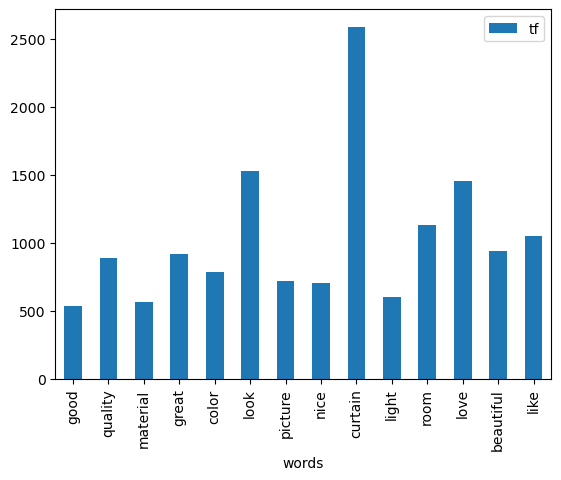

In [14]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

### Adım 2: WordCloud görselleştirme işlemi için;

#### a. "Review" değişkeninin içerdiği tüm kelimeleri "text" isminde string olarak kaydediniz.

In [15]:
text = " ".join(i for i in df.Review)
text

'happy good quality material however panel product fun bedroom windowsbr imagery bit stretched still material lightweight sheer appreciate lo que e que un poco ma great bang buck cant believe quality material vibrant color style work beautifully tie together look different photo exactly looking heavy material great price fast looking picture thought curtain would thinner sheer nice thickness weight help insulate front window look absolutely perfect arrived quickly pleased purchase much thought would wasnt really expecting wanting use curtain picture show rd set ambesonne curtain one set use spring summer one autumn set christmas winter durable color vibrant recommend curtain block view living room front door area dont mess easily seen visitor put christmas light around really brightens everything private closed darkening point dont block light work fine night curtain sheer daytime labeled darkening curtain fault ordering  love curtain printed polyester type material back material white

#### b. WordCloud kullanarak şablon şeklinizi belirleyip kaydediniz.

In [16]:
tr_mask = np.array(Image.open("tr.png"))

#### c.Kaydettiğiniz wordcloud'u ilk adımda oluşturduğunuz string ile generate ediniz

In [17]:
wordcloud = WordCloud(background_color = "white", 
                      max_words = 300, 
                      mask = tr_mask, 
                      contour_width = 3, 
                      contour_color="firebrick")
wordcloud.generate(text)

#### d. Görselleştirme adımlarını tamamlayınız. (figure, imshow, axis, show)

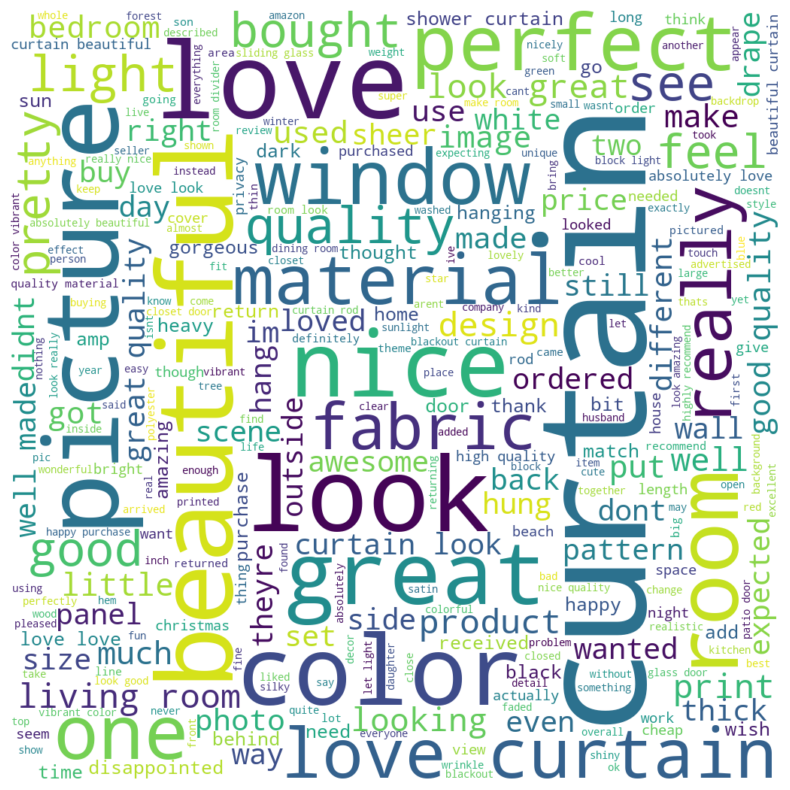

In [18]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Görev 3: Duygu Analizi

### Adım 1: Python içerisindeki NLTK paketinde tanımlanmış olan SentimentIntensityAnalyzer nesnesini oluşturunuz.

In [12]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\berka\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
sia = SentimentIntensityAnalyzer()

### Adım 2: SentimentIntensityAnalyzer nesnesi ile polarite puanlarını inceleyiniz;

#### a. "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplayınız

In [14]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...
2    {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

#### b. İncelenen ilk 10 gözlem için compund skorlarına göre filtreleyerek tekrar gözlemleyiniz.

In [15]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

#### c. 10 gözlem için compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelleyiniz

In [16]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

#### d. "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e ekleyiniz.

In [17]:
df["polarity_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df

,Star,HelpFul,Title,Review,polarity_label
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,pos
3,5,0,Que se ven elegantes muy finas,lo que e que un poco ma,neg
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,pos
...,...,...,...,...,...
5606,4,0,Recommend,great product reasonable money delivered quick...,pos
5607,5,0,"Terrible , different colors. I returned",color way panel match,neg
5608,5,0,Extremely pleasing,great studio complement entire theme area phot...,pos
5609,5,0,Perfect,brought beauty kid room love,pos


## Görev 4: Makine Öğrenmesine Hazırlık

### Adım 1: Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olarak ayırınız.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = df["Review"]
y = df["polarity_label"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Adım 2: Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte;

#### a. TfidfVectorizer kullanarak bir nesne oluşturunuz.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)

#### b. Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz.

In [23]:
# X_train veri seti için
X_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)

In [24]:
# X_test veri seti içim
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

## Görev 5: Modelleme (Lojistik Regresyon)

### Adım 1: Lojistik regresyon modelini kurarak train dataları ile fit ediniz.

In [25]:
log_model = LogisticRegression().fit(X_train_tf_idf_word, y_train)

### Adım 2: Kurmuş olduğunuz model ile tahmin işlemleri gerçekleştiriniz;

#### a. Predict fonksiyonu ile test datasını tahmin ederek kaydediniz.

In [26]:
y_pred = log_model.predict(X_test_tf_idf_word)

#### b. classification_report ile tahmin sonuçlarınızı raporlayıp gözlemleyiniz

In [27]:
from sklearn.metrics import classification_report

In [28]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         neg       0.34      0.91      0.49        77
         pos       0.99      0.90      0.94      1326

    accuracy                           0.90      1403
   macro avg       0.67      0.90      0.72      1403
weighted avg       0.96      0.90      0.92      1403



#### c. cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.

In [29]:
cross_val_score(log_model, X_test_tf_idf_word, y_test, cv = 5).mean()

0.8631520081342146

### Adım 3: Veride bulunan yorumlardan ratgele seçerek modele sorulması;

#### a. sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçerek yeni bir değere atayınız.

In [35]:
random_review = pd.Series(df["Review"].sample(1).values)

#### b. Elde ettiğiniz örneklemi modelin tahmin edebilmesi için CountVectorizer ile vektörleştiriniz.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
vectorizer = CountVectorizer().fit(X_train)

In [38]:
yeni_yorum = vectorizer.transform(random_review)

#### c. Vektörleştirdiğiniz örneklemi fit ve transform işlemlerini yaparak kaydediniz.

In [39]:
random_review_pred = log_model.predict(yeni_yorum)

#### e. Örneklemi ve tahmin sonucunu ekrana yazdırınız

In [41]:
print(f"Random Review: {random_review[0]} Predict: {random_review_pred[0]}")

Random Review: ordered delivered happy Predict: pos


## Görev 6: Modelleme (Random Forest)

### Adım 1: Random Forest modeli ile tahmin sonuçlarının gözlenmesi;

#### a. RandomForestClassifier modelini kurup fit ediniz.

In [44]:
rf_model = RandomForestClassifier().fit(X_train_tf_idf_word, y_train)

#### b. Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız

In [45]:
cross_val_score(rf_model, X_test_tf_idf_word, y_test, cv=5).mean()

0.8938179969496696

#### c. Lojistik regresyon modeli ile sonuçları karşılaştırınız.

Lojistik Regresyon modelinin çapraz doğrulama skoru 0.8631 iken RandomForest modelinin çapraz doğrulama skoru 0.8938'dir. Bu nedenle Random Forest algoritması daha doğru tahminlemeler yapacağından bu projede RandomForest algoritmasının kullanılması daha uygundur.